In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from six import iteritems
import scipy as sp
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns

from common import (
    get_params,
    plot,
    convert_spikes,
)

In [2]:
def read_spikes(filename):
    return np.loadtxt(
        filename,
        delimiter=",",
        skiprows=1,
        dtype={"names": ("time", "id"), "formats": (float, np.int64)},
    )

In [3]:
def make_sdf(sT, t0, tmax, dt, sigma):
    time = np.round(np.arange(t0-3*sigma, tmax+3*sigma, dt), 3)
    sdfs = np.zeros_like(time)

    kwdt = np.round(3*sigma, 3)
    print(kwdt)
    x = np.arange(-kwdt, kwdt, dt)
    x = np.exp(-np.power(x, 2)/(2*sigma*sigma))
    x = x/(sigma*np.sqrt(2.0*np.pi))

    if sT is not None:
        for t in sT:
            left = int((t - t0 - kwdt) / dt)
            right = int((t - t0 + kwdt) / dt)
            sdfs[left:right] += x
    return time, sdfs


In [4]:
def get_masks(times, params):
    return (np.where(times < params["record_time_ms"]), np.where(times > (params["duration_ms"] - params["record_time_ms"])))

In [5]:
def get_sdf_masks(times, sigma, params):
    return (
        np.where((times > (3.0 * sigma)) & (times < (params["record_time_ms"] - (3.0 * sigma)))),
        np.where(
            (times > (params["duration_ms"] - params["record_time_ms"] + (3.0 * sigma)))
            & (times < (params["duration_ms"] - (3.0 * sigma)))
        ),
    )

In [6]:
def stimuli_type(s1, s2, s3, t1, t2):
    if (s1==0 and s2==1 and s3==2):
        return (t1, t2)
    else:
        return (0, 0)

In [7]:
num_neurons = 1000
params = get_params(build_model=True, measure_timing=False, use_genn_recording=True)
params["sigma"] = 0.5
e_spikes = read_spikes(f"{params['cwd']}/{params['csv_path']}/{params['dt1']}_{params['dt2']}_izhikevich_e_spikes.csv") 
i_spikes = read_spikes(f"{params['cwd']}/{params['csv_path']}/{params['dt1']}_{params['dt2']}_izhikevich_i_spikes.csv")
# Read stimuli
stimuli = np.loadtxt(
    f"{params['cwd']}/{params['csv_path']}/{params['dt1']}_{params['dt2']}_izhikevich_stimulus_times.csv",
    delimiter=",",
    dtype={"names": ("time", "id1", "id2", "id3", "t1", "t2"), "formats": (float, np.int64, np.int64, np.int64, np.int64, np.int64)},
)
# Read rewards
reward_times = np.loadtxt(f"{params['cwd']}/{params['csv_path']}/{params['dt1']}_{params['dt2']}_izhikevich_reward_times.csv", dtype=float)
e_spike_first_second, e_spike_last_second = get_masks(e_spikes["time"], params)
i_spike_first_second, i_spike_last_second = get_masks(i_spikes["time"], params)
e_spike_sdf_first_second, e_spike_sdf_last_second = get_sdf_masks(
    e_spikes["time"], params["sigma"], params
)
i_spike_sdf_first_second, i_spike_sdf_last_second = get_sdf_masks(
    i_spikes["time"], params["sigma"], params
)
# Plot spikes that occur in first second
# first_second_sdf_spikes = np.concatenate(
#     (
#         e_spikes["time"][e_spike_sdf_first_second],
#         i_spikes["time"][i_spike_sdf_first_second],
#     )
# )
# first_second_sdf = (
#     make_sdf(first_second_sdf_spikes, 0.0, params["record_time_ms"], 0.1, params["sigma"]) / num_neurons
# )
# Plot spikes that occur in final second
last_second_sdf_spikes = np.concatenate(
    (
        e_spikes["time"][e_spike_sdf_last_second],
        i_spikes["time"][i_spike_sdf_last_second],
    )
)
last_second_sdf = make_sdf(last_second_sdf_spikes, params["duration_ms"] - params["record_time_ms"], params["duration_ms"], 0.1, params["sigma"])



1.5


In [8]:
np.random.seed(1234)

# Generate stimuli sets of neuron IDs
num_cells = params["num_excitatory"] + params["num_inhibitory"]
from time import perf_counter
stim_gen_start_time = perf_counter()
input_sets = [
    np.random.choice(num_cells, params["stimuli_set_size"], replace=False)
    for _ in range(params["num_stimuli_sets"])
]

In [9]:
def weight_in_out_plot(input_numpy_type_peak_t1_t2ay):
    indegree=input_numpy_type_peak_t1_t2ay.sum(axis=0)
    outdegree=input_numpy_type_peak_t1_t2ay.sum(axis=1)
    return indegree, outdegree

In [10]:
time_captured = 3540
df_weight = pd.DataFrame()
for dt1 in range(1, 5):
    for dt2 in range(1, 5):
        g_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_data.npy"%(params['cwd'],params['record_path'],dt1,dt2,time_captured))
        row_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_row.npy"%(params['cwd'],params['record_path'],dt1,dt2,time_captured))
        col_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_col.npy"%(params['cwd'],params['record_path'],dt1,dt2,time_captured))
        ee_dense = sp.sparse.csr_matrix((g_e_e,(row_e_e,col_e_e))).todense()
        indegree, outdegree = weight_in_out_plot(ee_dense)
        indegree = np.ravel(indegree)
        outdegree = np.ravel(outdegree)
        indegree_s0 = indegree[input_sets[0][np.where(input_sets[0]<800)]]
        outdegree_s0 = outdegree[input_sets[0][np.where(input_sets[0]<800)]]
        indegree_s1 = indegree[input_sets[1][np.where(input_sets[1]<800)]]
        outdegree_s1 = outdegree[input_sets[1][np.where(input_sets[1]<800)]]
        indegree_s2 = indegree[input_sets[2][np.where(input_sets[2]<800)]]
        outdegree_s2 = outdegree[input_sets[2][np.where(input_sets[2]<800)]]
        df_weight2 = pd.DataFrame({'indegree':indegree, 'outdegree':outdegree, 'group':[-1 for _ in indegree],  'dt1':[dt1 for _ in indegree], 'dt2':[dt2 for _ in indegree]})
        df_weight3 = pd.DataFrame({'indegree':indegree_s0, 'outdegree':outdegree_s0, 'group':[0 for _ in outdegree_s0],  'dt1':[dt1 for _ in outdegree_s0], 'dt2':[dt2 for _ in outdegree_s0]})
        df_weight4 = pd.DataFrame({'indegree':indegree_s1, 'outdegree':outdegree_s1, 'group':[1 for _ in outdegree_s1],  'dt1':[dt1 for _ in outdegree_s1], 'dt2':[dt2 for _ in outdegree_s1]})
        df_weight5 = pd.DataFrame({'indegree':indegree_s2, 'outdegree':outdegree_s2, 'group':[2 for _ in outdegree_s2],  'dt1':[dt1 for _ in outdegree_s2], 'dt2':[dt2 for _ in outdegree_s2]})
        df_weight = pd.concat([df_weight, df_weight2, df_weight3, df_weight4, df_weight5])

In [11]:
df_weight

,indegree,outdegree,group,dt1,dt2
0,192.563705,22.486294,-1,1,1
1,212.520279,18.056232,-1,1,1
2,187.976013,0.712629,-1,1,1
3,210.695267,29.295721,-1,1,1
4,129.263657,88.368462,-1,1,1
...,...,...,...,...,...
37,6.891274,313.548706,2,4,4
38,124.662544,108.533463,2,4,4
39,70.575241,202.354919,2,4,4
40,132.348206,126.712082,2,4,4


In [12]:
df_weight[(df_weight['dt1']==1)&(df_weight['dt2']==1)&(df_weight['group']==1)].std()

indegree     10.296703
outdegree    43.545929
group         0.000000
dt1           0.000000
dt2           0.000000
dtype: float64

In [13]:
df_weight_mean = pd.DataFrame()
df_weight_mean = df_weight.groupby(['dt1','dt2','group'])['indegree'].mean().reset_index()
df_weight_mean['indegree_sd'] = df_weight.groupby(['dt1','dt2','group'])['indegree'].std().reset_index()['indegree'].tolist()
df_weight_mean['outdegree'] = df_weight.groupby(['dt1','dt2','group'])['outdegree'].mean().reset_index()['outdegree'].tolist()
df_weight_mean['outdegree_sd'] = df_weight.groupby(['dt1','dt2','group'])['outdegree'].std().reset_index()['outdegree'].tolist()
df_weight_mean

,dt1,dt2,group,indegree,indegree_sd,outdegree,outdegree_sd
0,1,1,-1,121.326004,61.498539,121.326004,94.424309
1,1,1,0,13.141338,8.197451,297.124451,37.541606
2,1,1,1,23.981955,10.296704,275.975433,43.545927
3,1,1,2,38.960438,13.012205,259.075012,29.881648
4,1,2,-1,119.946625,59.916194,119.946625,94.166493
...,...,...,...,...,...,...,...
59,4,3,2,109.396683,41.412073,119.911415,69.737826
60,4,4,-1,116.378426,54.908322,116.378426,85.329230
61,4,4,0,15.988484,7.887145,279.585693,39.123576
62,4,4,1,51.237537,20.102923,231.819855,46.856179


In [14]:
df_weight_mean[df_weight_mean['group']==2][df_weight_mean['dt2']==2]

/tmp/ipykernel_8255/127490669.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_weight_mean[df_weight_mean['group']==2][df_weight_mean['dt2']==2]


,dt1,dt2,group,indegree,indegree_sd,outdegree,outdegree_sd
7,1,2,2,48.556068,24.723990,243.090332,46.185184
23,2,2,2,67.573914,36.888908,213.725906,65.576422
39,3,2,2,79.999237,37.056255,185.108322,58.791640
55,4,2,2,97.362839,35.348273,146.797760,60.000827


Text(0.5, 1.0, 'interval : 3ms, time : 3599s')

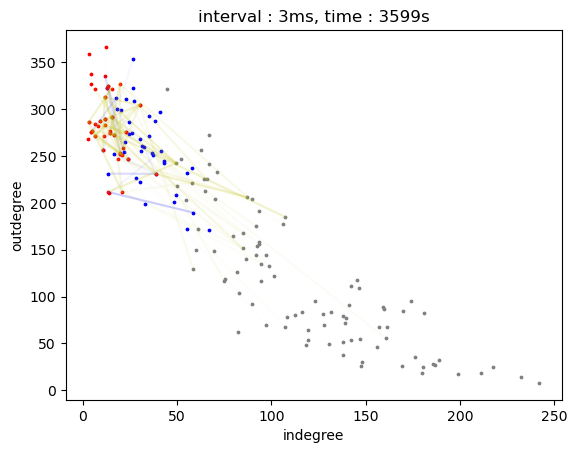

In [ ]:
g_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_data.npy"%(params['cwd'],params['record_path'],j,j,i))
row_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_row.npy"%(params['cwd'],params['record_path'],j,j,i))
col_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_col.npy"%(params['cwd'],params['record_path'],j,j,i))
ee_dense = sp.sparse.csr_matrix((g_e_e,(row_e_e,col_e_e))).todense()
indegree, outdegree = weight_in_out_plot(ee_dense)
indegree = np.ravel(indegree)
outdegree = np.ravel(outdegree)
indegree_s0 = indegree[input_sets[0][np.where(input_sets[0]<800)]]
outdegree_s0 = outdegree[input_sets[0][np.where(input_sets[0]<800)]]
indegree_s1 = indegree[input_sets[1][np.where(input_sets[1]<800)]]
outdegree_s1 = outdegree[input_sets[1][np.where(input_sets[1]<800)]]
indegree_s2 = indegree[input_sets[2][np.where(input_sets[2]<800)]]
outdegree_s2 = outdegree[input_sets[2][np.where(input_sets[2]<800)]]
indegree_s3 = indegree[other_ind]
outdegree_s3 = outdegree[other_ind]
plt.scatter(indegree_s3, outdegree_s3, s=3, color='gray', label = 'others')
plt.scatter(indegree_s1,outdegree_s1, s=3, color='blue', label = 's1')
plt.scatter(indegree_s0,outdegree_s0, s=3, color='red', label = 's0')
for s0i in s0_ind:
    for s1i in s1_ind:
        plt.plot([indegree[s0i], indegree[s1i]], [outdegree[s0i], outdegree[s1i]] ,'b-', alpha=ee[s1i][s0i]/20)
for s0i in s0_ind:
    for s1i in other_ind:
        plt.plot([indegree[s0i], indegree[s1i]], [outdegree[s0i], outdegree[s1i]] ,'y-',  alpha=ee[s1i][s0i]/20)
plt.xlabel('indegree')
plt.ylabel('outdegree')
plt.title('interval : %dms, time : %ds'%(j,i))

In [ ]:
connection_from_s0 = [np.sum(ee[s0_ind, i]) for i in range(800)]

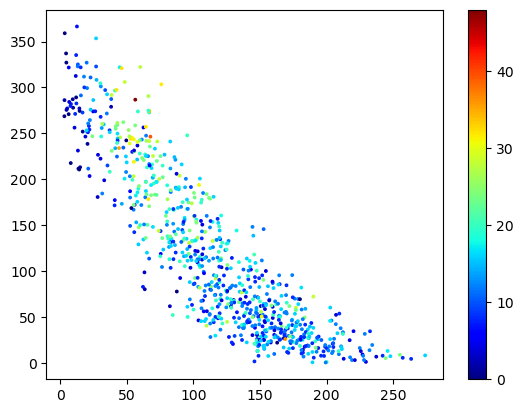

In [ ]:
g_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_data.npy"%(params['cwd'],params['record_path'],j,j,i))
row_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_row.npy"%(params['cwd'],params['record_path'],j,j,i))
col_e_e = np.load("%s/%s/%d,%dms interval, weight in %ds_col.npy"%(params['cwd'],params['record_path'],j,j,i))
ee_dense = sp.sparse.csr_matrix((g_e_e,(row_e_e,col_e_e))).todense()
indegree, outdegree = weight_in_out_plot(ee_dense)
indegree = np.ravel(indegree)
outdegree = np.ravel(outdegree)
indegree_s0 = indegree[input_sets[0][np.where(input_sets[0]<800)]]
outdegree_s0 = outdegree[input_sets[0][np.where(input_sets[0]<800)]]
indegree_s1 = indegree[input_sets[1][np.where(input_sets[1]<800)]]
outdegree_s1 = outdegree[input_sets[1][np.where(input_sets[1]<800)]]
indegree_s2 = indegree[input_sets[2][np.where(input_sets[2]<800)]]
outdegree_s2 = outdegree[input_sets[2][np.where(input_sets[2]<800)]]
indegree_s3 = indegree
outdegree_s3 = outdegree
plt.jet()
plt.scatter(indegree_s3, outdegree_s3, s=3, c=[np.sum(ee[s0_ind, i]) for i in range(800)])
plt.colorbar()